# Tutorial 6: Tensorflow 

## Topics covered
1. Tensorflow - Installation and Basics
3. Linear Regression
4. Building a MLP

## Tensorflow

Taken from: https://www.tensorflow.org/

TensorFlow™ is an open source software library for numerical computation using data flow graphs. Nodes in the graph represent mathematical operations, while the graph edges represent the multidimensional data arrays (tensors) communicated between them. The flexible architecture allows you to deploy computation to one or more CPUs or GPUs in a desktop, server, or mobile device with a single API. TensorFlow was originally developed by researchers and engineers working on the Google Brain Team within Google's Machine Intelligence research organization for the purposes of conducting machine learning and deep neural networks research, but the system is general enough to be applicable in a wide variety of other domains as well.

## Interesting Links and Tutorials
[Curated list of awesome Tensorflow experiments](https://github.com/jtoy/awesome-tensorflow)

[Video series on Tensorflow tutorials](https://www.youtube.com/watch?v=oYbVFhK_olY&list=PLSPWNkAMSvv5DKeSVDbEbUKSsK4Z-GgiP)

## Basics

**Installation**

https://www.tensorflow.org/install/

**Check available local devices**

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib

In [3]:
device_lib.list_local_devices()

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7661824848954545734]

**Variables and Placeholders**

In [14]:
tf.reset_default_graph()
sin_val = tf.sin(0.4)
pl_test = tf.placeholder(tf.float32)

with tf.Session() as sess:
    print(sess.run(sin_val))
    print(sess.run(pl_test, 
                   feed_dict={pl_test: 3}))

with tf.Session() as sess:
    print(sess.run(sin_val))
    print(sess.run(pl_test, 
                   feed_dict={pl_test: 4}))

0.389418
3.0
0.389418
4.0


**Namespace: Variable and Name scopes**

In [21]:
tf.reset_default_graph()

with tf.variable_scope('tut6'):
    a = tf.get_variable('a', [2, 1])
    b = tf.Variable(0., name='a')
    print(a.name)
    print(b.name)

with tf.variable_scope('tut6', reuse=True):
    b = tf.get_variable('a')
    print(b.name)

tut6/a:0
tut6/a_1:0
tut6/a:0


**Session**
1. Running computation graphs.
2. Get partition graphs allocations.

In [26]:
tf.reset_default_graph()
a = tf.Variable(1.)
sin_op = tf.sin(a)
init_var = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_var)
    print(sess.run(sin_op))

0.841471


**Example: Matrix power $M^{1000}$**

In [32]:
tf.reset_default_graph()

import numpy as np

def matpower(m, power=1000):
    ret = m
    for _ in range(power-1):
        ret = tf.matmul(ret, m)
    return ret

I = tf.Variable(np.eye(3))
I_m = matpower(I)
init_var = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_var)
    print(sess.run(I_m))

[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


**Sample example: Multiple GPUs**

$A^{1000} + B^{1000}$

In [34]:
A = tf.Variable(np.eye(3))
B = tf.Variable(np.eye(3))

with tf.device('/cpu:0'):
    A_m = matpower(A)

with tf.device('/cpu:0'):
    B_m = matpower(B)

sum_op = A_m + B_m
init_var = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_var)
    print(sess.run(sum_op))

[[ 2.  0.  0.]
 [ 0.  2.  0.]
 [ 0.  0.  2.]]


## Linear Regression

Fit a equation of line to the given data.

$$ Y = Mx + C$$

Variables|Placeholders
--- | ---
$M$ and $C$ | $Y$ and $X$

**STEP 1**: Get the data

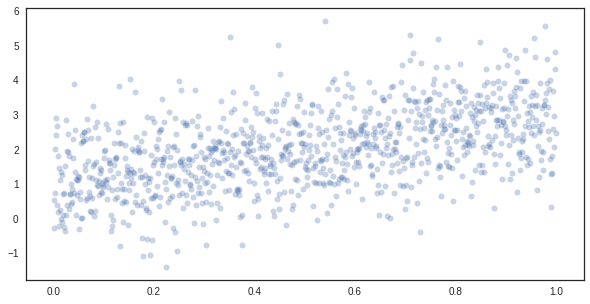

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

X = np.linspace(0, 1, 1000)
Y = 2.*X + 1. + np.random.randn(*X.shape)

plt.figure(figsize=(10, 5))
plt.scatter(X, Y, s=30, alpha=0.3)

**STEP 2**: Initialize tensorflow variables, loss function and gradient descend operations

In [45]:
tf.reset_default_graph()

M = tf.Variable(0.)
C = tf.Variable(0.)

_y = M*X + C
loss = tf.reduce_mean(tf.square(_y - Y))

init_var = tf.global_variables_initializer()
grad = tf.train.GradientDescentOptimizer(0.1)
train_op = grad.minimize(loss)

**STEP 3**: Perform the gradient descend

Plot the loss per iterations

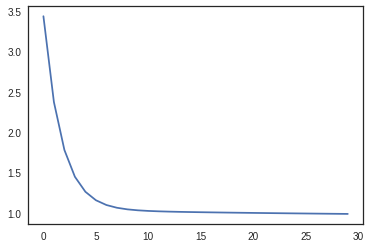

In [51]:
loss_history = []

with tf.Session() as sess:
    sess.run(init_var)
    
    for _ in range(30):
        sess.run(train_op)
        cur_loss = sess.run(loss)
        loss_history.append(cur_loss)
    M_p = sess.run(M)
    C_p = sess.run(C)

plt.plot(loss_history)

**STEP 4:** Final loss and plot the fitted line

$$Y = 1.22 \times X + 1.4$$

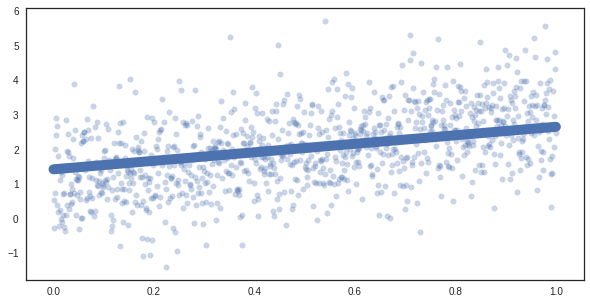

In [53]:
plt.figure(figsize=(10, 5))
plt.scatter(X, Y, s=30, alpha=0.3)
plt.plot(X, M_p*X + C_p, linewidth=10)

** More Exercise:** Can you fit $n$ degree polynomial? Write a generic function that takes value of $n$ and returns the computation model for:

$$Y = a_1 X^n + a_2 X^{n-1} ... + a_n$$

Rest everything should stay almost same. Can you tell why do we need `Placeholder` after solving the exercise?

## Multilayer Perceptron
**MLP Model**

1. Building two hidden layered neural network model. 
2. Each layer has Weights and Bias (variables to adjust). 
3. Activation of both layers is Sigmoid.
4. Activation for last layer is Softmax. 
4. Loss function is Cross Entropy.

**Unit**|**Output**
-|-
Input | $I$
Layer 1| $L_1 = sigmoid(I \times W_1 + B_1)$
Layer 2| $L_2 = Sigmoid(L_1 \times W_2 + B_2)$
Output | $out = L_2*W_{out} + B_{out}$
Loss | $loss(out, actual)$

**Tensorflow Variables**

|Layer|Variables|Size|
|-|-|
|Layer 1|$W_1$|$D \times N_1$|
|Layer 1|$B_1$|$D \times 1$|
|Layer 2|$W_2$|$N_1 \times N_2$|
|Layer 2|$B_2$|$N_2 \times 1$|
|Output|$W_{out}$|$N_2 \times O$|
|Output|$B_{out}$|$N_2 \times 1$|


In [54]:
import sklearn.datasets as data
import pandas as pd
iris = data.load_iris()

data = iris.data
targets = iris.target

In [140]:
pd.DataFrame(data)

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


In [143]:
data.shape

(150, 4)

In [142]:
len(np.unique(targets))

3

In [57]:
tf.reset_default_graph()

n_hidden_1 = 10
n_hidden_2 = 10
n_input = 4
n_classes = 3

weights = {
    'w1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'w2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [58]:
def multilayer_perceptron(x):
    # Hidden layer with Sigmoid activation
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.sigmoid(layer_1)
    # Hidden layer with Sigmoid activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.sigmoid(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

x = tf.placeholder('float32', shape=[None, n_input])
y = tf.placeholder('float32', shape=[None, n_classes])
model = multilayer_perceptron(x)

In [61]:
from keras.utils.np_utils import to_categorical

ts = to_categorical(targets)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.5).minimize(cost)

# Initializing the variables
init = tf.global_variables_initializer()

training_epochs = 100
correct_prediction = tf.equal(
    tf.argmax(y,1), tf.argmax(model,1))
accuracy = tf.reduce_mean(
    tf.cast(correct_prediction, tf.float32))

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        # Loop over all batches
        for i in np.arange(0, 150, 50):
            batch_x = data[i:i+50]
            batch_y = ts[i:i+50]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y})
            # Compute average loss
            avg_cost += c / 50
        # Display logs per epoch step

        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))
    print("Optimization Finished!")

    print("Accuracy:", sess.run(accuracy, feed_dict={x: data,
                                                    y: ts}))

Using Theano backend.


Epoch: 0001 cost= 0.389893675
Epoch: 0002 cost= 0.107827921
Epoch: 0003 cost= 0.094876857
Epoch: 0004 cost= 0.107055825
Epoch: 0005 cost= 0.100229117
Epoch: 0006 cost= 0.081400983
Epoch: 0007 cost= 0.073082807
Epoch: 0008 cost= 0.070463626
Epoch: 0009 cost= 0.068334399
Epoch: 0010 cost= 0.069870355
Epoch: 0011 cost= 0.073494639
Epoch: 0012 cost= 0.073639627
Epoch: 0013 cost= 0.071669853
Epoch: 0014 cost= 0.069933848
Epoch: 0015 cost= 0.069043138
Epoch: 0016 cost= 0.069131365
Epoch: 0017 cost= 0.070222583
Epoch: 0018 cost= 0.071135771
Epoch: 0019 cost= 0.071068301
Epoch: 0020 cost= 0.070431561
Epoch: 0021 cost= 0.069853494
Epoch: 0022 cost= 0.069663558
Epoch: 0023 cost= 0.069915791
Epoch: 0024 cost= 0.070343792
Epoch: 0025 cost= 0.070561910
Epoch: 0026 cost= 0.070463417
Epoch: 0027 cost= 0.070223823
Epoch: 0028 cost= 0.070056660
Epoch: 0029 cost= 0.070065320
Epoch: 0030 cost= 0.070207300
Epoch: 0031 cost= 0.070346863
Epoch: 0032 cost= 0.070382006
Epoch: 0033 cost= 0.070319941
Epoch: 003